Notebook to load synthetic reference datasets for the phase-mapping problem

In [1]:
!wget http://www.udiscover.it/downloads/materials/synthetic_instance_data.zip

--2021-07-20 00:16:09--  http://www.udiscover.it/downloads/materials/synthetic_instance_data.zip
Resolving www.udiscover.it (www.udiscover.it)... 208.118.251.110
Connecting to www.udiscover.it (www.udiscover.it)|208.118.251.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60184483 (57M) [application/zip]
Saving to: ‘synthetic_instance_data.zip’

synthetic_instance_ 100%[===================>]  57.40M  10.2MB/s    in 7.7s    

2021-07-20 00:16:17 (7.49 MB/s) - ‘synthetic_instance_data.zip’ saved [60184483/60184483]



In [2]:
!mkdir synth_data
!unzip synthetic_instance_data.zip -d synth_data

Archive:  synthetic_instance_data.zip
  inflating: synth_data/README       
  inflating: synth_data/synthinst100_t1_n9_p20_s1_inst.txt  
  inflating: synth_data/synthinst100_t1_n9_p20_s1_sol.txt  
  inflating: synth_data/synthinst101_t1_n9_p100_r20_s1_inst.txt  
  inflating: synth_data/synthinst101_t1_n9_p100_r20_s1_sol.txt  
  inflating: synth_data/synthinst102_t1_n9_p80_r20_s1_inst.txt  
  inflating: synth_data/synthinst102_t1_n9_p80_r20_s1_sol.txt  
  inflating: synth_data/synthinst103_t1_n9_p50_r20_s1_inst.txt  
  inflating: synth_data/synthinst103_t1_n9_p50_r20_s1_sol.txt  
  inflating: synth_data/synthinst104_t1_n9_p20_r20_s1_inst.txt  
  inflating: synth_data/synthinst104_t1_n9_p20_r20_s1_sol.txt  
  inflating: synth_data/synthinst105_t1_n9_p100_r50_s1_inst.txt  
  inflating: synth_data/synthinst105_t1_n9_p100_r50_s1_sol.txt  
  inflating: synth_data/synthinst106_t1_n9_p80_r50_s1_inst.txt  
  inflating: synth_data/synthinst106_t1_n9_p80_r50_s1_sol.txt  
  inflating: synth_data/s

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pdb

In [52]:
ls "/Users/ollie/Downloads/synthetic_instance_generator (2)/instances"

AlLiFe_n240_p100_inst.txt  AlLiFe_n240_p100_sol.txt


In [58]:
#prefix = "../xrdc/inputs/synthetic_instance_data/synthinst26_t0_n9_p80_s1{}"
#prefix = "synth_data/synthinst49_t0_n16_p100_s1{}"
prefix = "/Users/ollie/Downloads/synth_generator/AlLiFe_n240_p100{}"
solpath, instpath = prefix.format("_sol.txt"), prefix.format("_inst.txt")

In [59]:
ls $solpath

/Users/ollie/Downloads/synth_generator/AlLiFe_n240_p100_sol.txt


In [60]:
def to_df(d):
    return pd.DataFrame(d).T.values

def extract_row(key_lookup, name, val, key):
    try:
        rowname = int(name[1:])
    except ValueError:
        rowname = name[1:]
    key_lookup[key][rowname] = np.array(val.split(',')).astype(float)

def load_solution_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    # Simulated pattern for each sample
    dataset = {}
    # Basis pattern for each phase
    bases = {}
    # Phase fractions for each sample
    fractions = {}
    # Fractional q scale for each sample-phase combination
    shifts = {}
    # Peak width multiplier for each sample-phase combination
    widths = {}

    key_lookup = {'B': bases, 'C': fractions, 'S': shifts, 'W': widths}

    for l in lines:
        if '=' in l:
            name, val = l.split('=')
        if l[0] == 'K':
            n_phases = int(l[2:])
        elif l[0] in ['B', 'C', 'S', 'W']:
            extract_row(key_lookup, name, val, l[0])
        elif l[0] == 'Q':
            Q = np.array(l[2:].split(',')).astype(float) / 10 # convert to inverse Angstrom
        elif l[0] == 'R':
            sample_idx = int(name.split('_')[0][1:])
            dataset[sample_idx] = dataset.setdefault(sample_idx, np.zeros_like(Q)) +\
                np.array(val.split(',')).astype(float)

    dataset, bases, fractions, shifts, widths =\
        [to_df(d) for d in [dataset, bases, fractions, shifts, widths]]
    
    #return lines

    return Q, dataset, bases, fractions, shifts, widths, fractions.shape[0], n_phases


def load_instance_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    # Simulated pattern for each sample
    dataset = {}
    compositions = {}
    key_lookup = {'I': dataset, 'C': compositions}

    for l in lines:
        if '=' in l:
            name, val = l.split('=')
        if l[0] == 'M':
            n_components = int(l[2:])
        elif l[0] == 'N':
            n_samples = int(l[2:])
        elif l[0] == 'I':
            extract_row(key_lookup, name, val, l[0])
        elif l[0] == 'C' and len(l.split(',')) > 3:
            extract_row(key_lookup, name, val, l[0])
        elif l[0] == 'Q':
            Q = np.array(l[2:].split(',')).astype(float) / 10 # convert to inverse Angstrom

    dataset =  to_df(dataset)
    compositions = to_df(compositions)
    return Q, dataset, n_samples, compositions

### Load simulated obervational data:

In [61]:
Q, dataset, n_samples, compositions = load_instance_file(instpath)

In [62]:
dataset.shape

(28920, 650)

In [63]:
# species fractions, e.g. CAl,CLi,CFe
assert compositions.shape == (3, n_samples)
assert np.isclose(compositions.sum(axis = 0), 1, .02).all()

### Load solution data (theoretical ground truth phase distribution +  shifts and peak widths):

In [115]:
Q, dataset, bases, fractions, shifts, widths, n_samples, n_phases = load_solution_file(solpath)

In [65]:
assert fractions.shape[1] == shifts.shape[1] == widths.shape[1] == n_phases
assert fractions.shape[0] == shifts.shape[0] == widths.shape[0]

In [71]:
from xrdc import featurization as feat

In [101]:
mask = ((fractions!= 0).sum(axis = 1) == 3)

In [106]:
(fractions != 0) == np.array([ True, False,  True,  True, False, False])

array([[False,  True,  True, False,  True,  True],
       [False,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True],
       ...,
       [ True,  True, False, False,  True,  True],
       [ True,  True, False,  True,  True,  True],
       [ True,  True, False, False,  True,  True]])

In [117]:
# shifts[shifts == 0] += 1

In [118]:
shifts

array([[1.      , 1.      , 1.      , 1.      , 1.      , 1.      ],
       [1.      , 1.      , 1.      , 0.936226, 1.      , 1.      ],
       [1.      , 1.      , 1.      , 0.936226, 1.      , 1.      ],
       ...,
       [0.999771, 1.      , 1.      , 1.      , 1.      , 1.      ],
       [1.      , 1.      , 1.      , 1.      , 1.      , 1.      ],
       [1.      , 1.      , 1.      , 1.      , 1.      , 1.      ]])

In [142]:
composition_similarity = feat.csim_pairs(compositions[:, :2000].T)

In [ ]:
np.argsort(composition_similarity)

In [141]:
shift_similarity = feat.csim_pairs(shifts[:2000, :])

(array([453118.,  23960.,   8628.,  13412.,      0.,      0.,      0.,
             0.,      0., 500882.]),
 array([0.99971158, 0.99974043, 0.99976927, 0.99979811, 0.99982695,
        0.99985579, 0.99988463, 0.99991348, 0.99994232, 0.99997116,
        1.        ]),
 <BarContainer object of 10 artists>)

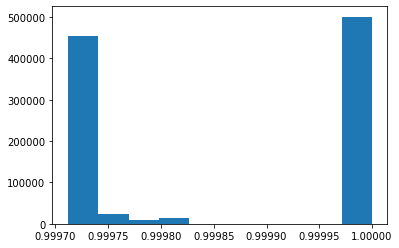

In [132]:
plt.hist(shift_similarity.ravel())

In [138]:
shift_similarity[shift_similarity >= 1] = np.nan

In [139]:
shift_similarity

array([[       nan, 0.99971158, 0.99971158, ..., 0.99972357, 0.99972372,
        0.99972389],
       [0.99971158,        nan,        nan, ..., 0.99999987, 0.99999987,
        0.99999987],
       [0.99971158,        nan,        nan, ..., 0.99999987, 0.99999987,
        0.99999987],
       ...,
       [0.99972357, 0.99999987, 0.99999987, ...,        nan, 1.        ,
        1.        ],
       [0.99972372, 0.99999987, 0.99999987, ..., 1.        , 1.        ,
        1.        ],
       [0.99972389, 0.99999987, 0.99999987, ..., 1.        , 1.        ,
               nan]])

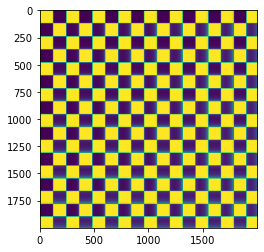

In [143]:
plt.imshow(shift_similarity)

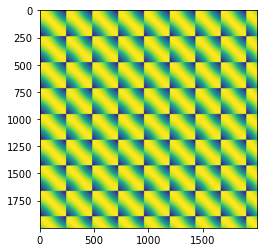

In [144]:
plt.imshow(composition_similarity)

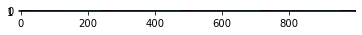

In [127]:
plt.imshow(compositions[:2, :1000])

In [89]:
from scipy.stats import pearsonr

In [90]:
pearsonr(shift_similarity[0], composition_similarity[0])

(0.5337624977580504, 1.0049126533766971e-74)

In [82]:
shifts[:1000, :].shape


(1000, 6)

In [69]:
shifts

array([[0.      , 0.      , 1.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 1.      , 0.936226, 0.      , 0.      ],
       [0.      , 0.      , 1.      , 0.936226, 0.      , 0.      ],
       ...,
       [0.999771, 0.      , 0.      , 0.      , 0.      , 0.      ],
       [1.      , 0.      , 0.      , 1.      , 0.      , 0.      ],
       [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ]])

#### Example: the second pattern in this dataset contains two phase contributions. The contribution of the phase with index 3 is q-scaled by a factor of .936226.

[0.       0.       1.       0.936226 0.       0.      ]


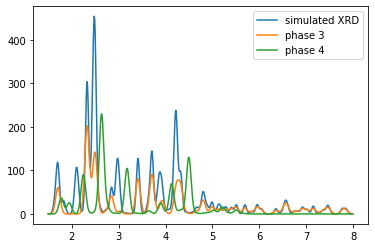

In [10]:
print(shifts[1])
plt.plot(Q, dataset[1], label = 'simulated XRD')
plt.plot(Q, bases[2] * fractions[1][2], label = 'phase 3')
plt.plot(Q, bases[3] * fractions[1][3], label = 'phase 4')
plt.legend()

In [11]:
print("number of phases:", n_phases)
print("number of samples:", n_samples)
#print("q array (inverse Angstrom):", Q)

number of phases: 6
number of samples: 136


In [13]:
compositions.shape

(3, 136)

In [12]:
# from PyWaveletPeakID import PyWaveletPeakID as pywaves

# waves, scales=pywaves.getwavesetfromdatabase([2., 33., 70., 130.]) # the scales must be a subset of those in the database, otherwise the closest available scale will be used

# sg=pywaves.scalegrid_scalesubset(stopscale=80.,startscale=2.,scalemultiplier=1.5)
# scalevals=pywaves.scale_scalegrid_ind(sg)

# wtset=pywaves.wavetrans1d(dataset, waves[:3], scalevals=scalevals)